In [21]:
#Import necessary packages

using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using LabelledArrays
using OrdinaryDiffEq
using Plots
using Catlab

#Defining a personalised uwd 

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, graph_attrs=Dict(
        "layout" => "neato",
        "bgcolor" => "white",
        "overlap" => "false",
        "splines" => "true"
    ),
    node_attrs=Dict(
        "shape" => "circle",
        "style" => "filled",
        "fillcolor" => "lightblue",
        "fontname" => "Calibri",
        "fontsize" => "10"
    ),
    edge_attrs=Dict(
        "color" => "red",
        "penwidth" => "1"
    ))

display_uwd (generic function with 1 method)

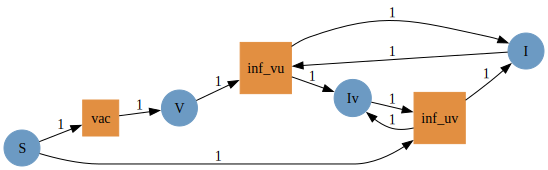

In [19]:
sir = Open(LabelledPetriNet(
    [:S, :I, :R],
    :inf_u=>(:S, :I)=>(:I, :I),
    :rec_u=>:I=>:R))
to_graphviz(sir)

vivr = Open(LabelledPetriNet(
    [:V, :Iv, :R],
    :inf_v=>(:V, :Iv)=>(:Iv, :Iv),
    :rec_v=>:Iv=>:R))

cross_exp = Open(LabelledPetriNet(
    [:S, :V, :I, :Iv],
    :vac=>:S=>:V,
    :inf_uv=>(:S, :Iv)=>(:I ,:Iv),
    :inf_vu=>(:V, :I)=>(:Iv , :I)))

to_graphviz(cross_exp, program="neato")
    

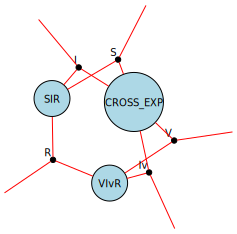

In [27]:
SVIIvR_comp_pattern = @relation (S, V, I, Iv, R) begin
    SIR(S,I,R)
    VIvR(V,Iv,R)
    CROSS_EXP(S,V,I,Iv)
end
display_uwd(SVIIvR_comp_pattern)

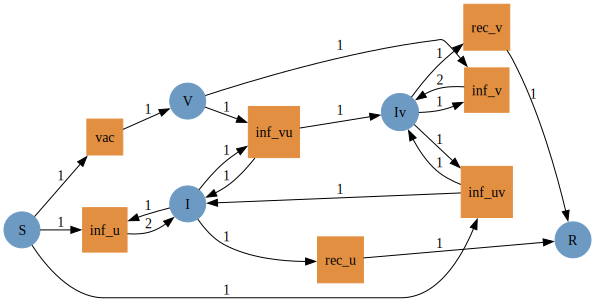

In [29]:
SVIIvR = oapply(SVIIvR_comp_pattern, Dict( 
        :SIR => sir, 
        :VIvR => vivr, 
        :CROSS_EXP => cross_exp 
)) |> apex 

to_graphviz(SVIIvR,program="neato")

In [31]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics.Graphviz
using Catlab.Graphics.Graphviz: Html 
using AlgebraicPetri

In [70]:
 # Helper for graphing typed Petri nets 
colors = ["#a08eae","#ffeec6", "#a8dcd9", "#ffeec6", "#a8dcd9"] 
 
function def_trans(typed_petri::ACSetTransformation, colors; labels = true) 
  (p, t; pos = "") -> ("t$t", Attributes( 
             :label => labels ? Html(flatten(tname(p,t))) : "" , 
             :shape=>"square", 
             :color=>colors[typed_petri[:T](t)], 
             :pos=>pos)) 
end 
 
function def_trans(colors = colors; labels = true) 
  (p, t; pos = "") -> ("t$t", Attributes( 
             :label => labels ? "$(tname(p, t))" : "" , 
             :shape=>"square", 
             :color=>colors[t], 
             :pos=>pos)) 
end 
 
flatten(tname::Symbol) = "$tname" 
 
function flatten(tname::Tuple) 
    names = split(replace(string(tname), "("=>"", ")"=>"", ":"=>""), ",") 
    for i in 1:length(names) 
        name = strip(names[i]) 
        if name[1:2] == "id" 
            continue 
        end 
        return name 
    end 
    return "id" 
end 
 
def_states(p, s; pos="") = ("s$s", Attributes( 
        :label => sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)))) :  ":"=>"", "," => "<BR/>"
        :shape=>"circle", 
        :color=>"#6C9AC3", 
        :pos=>pos 
)) 
 
Graph_typed(typed_petri::ACSetTransformation, colors = colors; labels = true) = to_graphviz(dom(typed_petri), 
    make_trans = def_trans(typed_petri, colors; labels = labels), 
    make_states = def_states 
) 

Graph_typed (generic function with 2 methods)

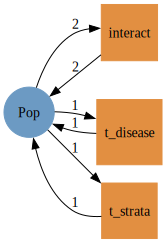

In [61]:
 infectious_type = LabelledPetriNet([:Pop], 
:interact=>((:Pop, :Pop)=>(:Pop, :Pop)),  
:t_disease=>(:Pop=>:Pop), 
:t_strata=>(:Pop=>:Pop) 
) 
Graph_typed(id(infectious_type)) 

In [49]:
s, = parts(infectious_type, :S) 
t_interact, t_disease, t_strata = parts(infectious_type, :T) 
i_interact1, i_interact2, i_disease, i_strata = parts(infectious_type, :I) 
o_interact1, o_interact2, o_disease, o_strata = parts(infectious_type, :O); 
infectious_type = map(infectious_type, Name=name->nothing); 

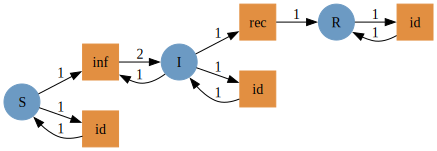

In [50]:
SIR = LabelledPetriNet([:S, :I, :R], 
:inf => ((:S, :I)=>(:I, :I)), 
:rec => (:I=>:R), 
:id => (:S => :S), 
:id => (:I => :I), 
:id => (:R => :R) 
) 
typed_SIR = ACSetTransformation(SIR, infectious_type, 
S = [s, s, s], 
T = [t_interact, t_disease, t_strata, t_strata, t_strata], 
I = [i_interact1, i_interact2, i_disease, i_strata, i_strata, i_strata], 
O = [o_interact1, o_interact2, o_disease, o_strata, o_strata, o_strata], 
Name = name -> nothing # specify the mapping for the loose ACSet transform 
); 
@assert is_natural(typed_SIR) 
Graph_typed(typed_SIR)

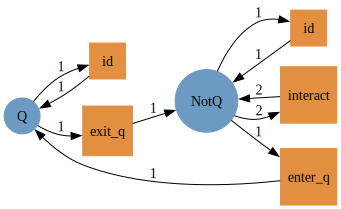

In [52]:
 quarantine = LabelledPetriNet([:Q, :NotQ], 
:id => (:Q => :Q), 
:id => (:NotQ => :NotQ), 
:enter_q => (:NotQ => :Q), 
:exit_q => (:Q => :NotQ), 
:interact => ((:NotQ, :NotQ) => (:NotQ, :NotQ)) 
) 
typed_quarantine = ACSetTransformation(quarantine, infectious_type, 
S = [s, s], 
T = [t_disease, t_disease, t_strata, t_strata, t_interact], 
I = [i_disease, i_disease, i_strata, i_strata, i_interact1, i_interact2], 
O = [o_disease, o_disease, o_strata, o_strata, o_interact1, o_interact2], 
Name = name -> nothing 
) 
@assert is_natural(typed_quarantine) 
Graph_typed(typed_quarantine) 

In [53]:
stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2)) 
typed_stratify(typed_model1, typed_model2) = 
compose(proj1(pullback(typed_model1, typed_model2)), typed_model1); 

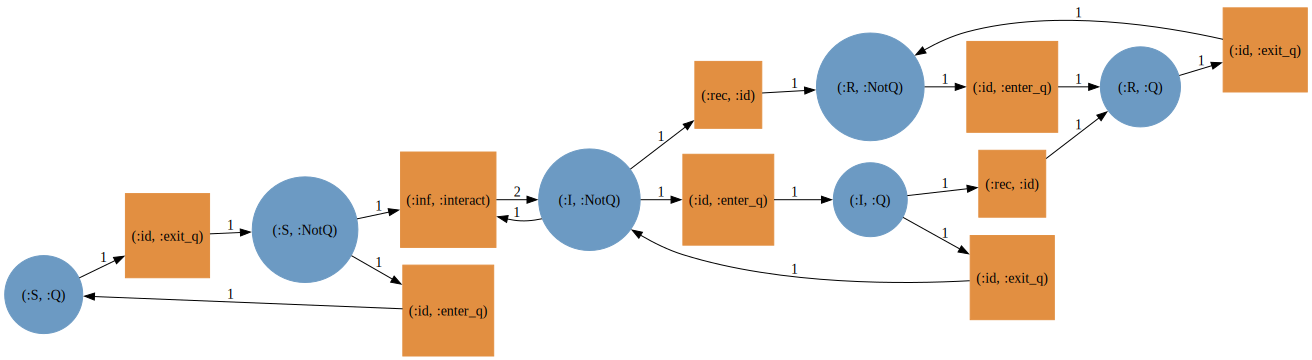

In [64]:
typed_stratified_model = typed_stratify(typed_SIR, typed_quarantine) 
Graph_typed(typed_stratified_model) 